Interactively figure out MGRS tiles and track numbers

In [3]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [49]:
yaml_file = 'events/yajiang_fire_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'yajiang_fire_2024',
 'bounds': [100.96162212, 30.03892945, 101.33076217, 30.23238956],
 'event_date': '2024-03-15',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [76, 127],
 'mgrs_tiles': ['47RQP', '47RPP'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'UNOSAT via humanitarian data exchange',
 'links': ['https://data.humdata.org/dataset/the-wildfire-area-of-yajiang-country-sichuan-province-china via SDGSAT-1 MSI - March 3 and March 19',
  'https://www.rfa.org/english/news/tibet/sichuan-wildfires-03182024171046.html']}

# Read Geojson

In [50]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

In [51]:
# df_event.plot()

In [52]:
df_event.head()

name       date                              source_id  \
0  yajiang_fire_2024 2024-03-15  UNOSAT via humanitarian data exchange   
1  yajiang_fire_2024 2024-03-15  UNOSAT via humanitarian data exchange   
2  yajiang_fire_2024 2024-03-15  UNOSAT via humanitarian data exchange   
3  yajiang_fire_2024 2024-03-15  UNOSAT via humanitarian data exchange   
4  yajiang_fire_2024 2024-03-15  UNOSAT via humanitarian data exchange   

                                            geometry  
0  POLYGON ((101.06769 30.05566, 101.06494 30.055...  
1  POLYGON ((101.05103 30.06223, 101.04967 30.062...  
2  POLYGON ((101.21657 30.11180, 101.22008 30.112...  
3  POLYGON ((101.26192 30.12477, 101.26217 30.124...  
4  POLYGON ((101.04677 30.12737, 101.05013 30.127...

In [53]:
df_event.total_bounds

array([100.96162212,  30.03892945, 101.33076217,  30.23238956])

# Create Spatial AOI

In [54]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [55]:
bounds = aoi.bounds
bounds

(100.96162212124922,
 30.038929452596218,
 101.33076217281322,
 30.232389564514655)

# Find MGRS tiles and Explore

In [56]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(179, -60, 180, 60))]

df_mgrs_overlapping.head()

tile_id    epsg                                            utm_wkt  \
1   47RPP   32647  MULTIPOLYGON(((600000 3400020,600000 3290220,7...   
2   47RQP   32647  MULTIPOLYGON(((699960 3400020,699960 3290220,8...   

                                            geometry  
1  MULTIPOLYGON (((100.04452 30.72887, 100.03410 ...  
2  MULTIPOLYGON (((101.08819 30.71627, 101.06736 ...

In [57]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [58]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['47RQP', '47RPP']

In [59]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

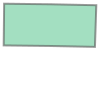

In [60]:
search_geo

# Explore Availability of RTC Data

In [61]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [62]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

["'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 10 simplified to 6 with proximity threshold of 0.004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


612

In [63]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

["'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 10 simplified to 6 with proximity threshold of 0.004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


275

In [64]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [65]:
df_rtc_resp_pre_e.pathNumber.unique()

array([ 62,  33,  26, 135,  99, 128])

In [68]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([26, 135])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [67]:
df_rtc_resp_post_e.head()

geometry  centerLat   centerLon  \
0  POLYGON ((102.99292 29.61815, 102.15485 29.744...  29.598724  102.556349   
1  POLYGON ((103.02774 29.78420, 102.18585 29.911...  29.764668  102.590494   
2  POLYGON ((103.06170 29.95012, 102.21981 30.076...  29.930563  102.623914   
3  POLYGON ((100.63082 29.64171, 99.72601 29.7900...  29.632642  100.161629   
4  POLYGON ((100.66843 29.80790, 99.75833 29.9567...  29.799160  100.196053   

               stopTime                                             fileID  \
0  2024-05-13T23:05:37Z  OPERA_L2_RTC-S1_T062-131924-IW3_20240513T23053...   
1  2024-05-13T23:05:34Z  OPERA_L2_RTC-S1_T062-131923-IW3_20240513T23053...   
2  2024-05-13T23:05:31Z  OPERA_L2_RTC-S1_T062-131922-IW3_20240513T23052...   
3  2024-05-11T23:22:00Z  OPERA_L2_RTC-S1_T033-069633-IW1_20240511T23215...   
4  2024-05-11T23:21:57Z  OPERA_L2_RTC-S1_T033-069632-IW1_20240511T23215...   

  flightDirection  pathNumber processingLevel  \
0      DESCENDING          62             RTC   
1      DESCENDING          62             RTC   
2      DESCENDING          62             RTC   
3      DESCENDING          33             RTC   
4      DESCENDING          33             RTC   

                                                 url             startTime  \
0  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-05-13T23:05:34Z   
1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-05-13T23:05:31Z   
2  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-05-13T23:05:28Z   
3  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-05-11T23:21:57Z   
4  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2024-05-11T23:21:54Z   

   ... validityStartDate subswath  \
0  ...              None      IW3   
1  ...              None      IW3   
2  ...              None      IW3   
3  ...              None      IW1   
4  ...              None      IW1   

                                            fileName beamModeType  \
0  OPERA_L2_RTC-S1_T062-131924-IW3_20240513T23053...           IW   
1  OPERA_L2_RTC-S1_T062-131923-IW3_20240513T23053...           IW   
2  OPERA_L2_RTC-S1_T062-131922-IW3_20240513T23052...           IW   
3  OPERA_L2_RTC-S1_T033-069633-IW1_20240511T23215...           IW   
4  OPERA_L2_RTC-S1_T033-069632-IW1_20240511T23215...           IW   

                                              s3Urls beamMode  \
0  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
1  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
2  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
3  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
4  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   

                                      additionalUrls bistaticDelayCorrection  \
0  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
1  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
2  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
3  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
4  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   

  noiseCorrection postProcessingFilter  
0            TRUE                FALSE  
1            TRUE                FALSE  
2            TRUE                FALSE  
3            TRUE                FALSE  
4            TRUE                FALSE  

[5 rows x 33 columns]